In [1]:
%pip install gymnasium

import gymnasium as gym

env = gym.make('Blackjack-v1')

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

def simple_policy(state):
    player_sum, _, _ = state
    return 0 if player_sum >= 17 else 1

def generate_episode(env, policy):

    episode = []
    state, _ = env.reset()
    done = False
    while not done:
        action = policy(state)
        next_state, reward, done, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done or truncated:
            break
    return episode

def mc_prediction(env, policy, num_episodes):
    V = {}
    N = {}

    for _ in range(num_episodes):
        episode = generate_episode(env, policy)
        states_in_episode = set([x[0] for x in episode])

        G = 0
        for i in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[i]
            G += reward
            if state not in [x[0] for x in episode[:i]]:
                if state not in V:
                    V[state] = 0
                    N[state] = 0
                N[state] += 1
                V[state] += (G - V[state]) / N[state]

    return V

num_episodes = 10000
V = mc_prediction(env, simple_policy, num_episodes)

print(f"Estimated value function after {num_episodes} episodes:")
for state, value in list(V.items())[:10]:
    print(f"State: {state}, Value: {value:.4f}")

Estimated value function after 10000 episodes:
State: (20, 10, 0), Value: 0.3955
State: (12, 10, 0), Value: -0.4305
State: (14, 2, 0), Value: -0.4900
State: (17, 10, 0), Value: -0.4665
State: (18, 6, 0), Value: 0.3158
State: (13, 6, 0), Value: -0.2821
State: (10, 6, 0), Value: 0.3667
State: (17, 6, 0), Value: 0.0227
State: (19, 6, 0), Value: 0.5190
State: (9, 6, 0), Value: 0.2727


In [3]:
import collections

def epsilon_greedy_policy(Q, state, epsilon, nA):
    if state not in Q:
        return np.random.choice(nA)

    best_action = np.argmax(Q[state])

    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(nA)
    else:
        return best_action

def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=1.0, epsilon_decay=0.999):

    Q = collections.defaultdict(lambda: np.zeros(env.action_space.n))
    N = collections.defaultdict(lambda: np.zeros(env.action_space.n))

    for i_episode in range(num_episodes):
        epsilon = max(0.01, epsilon * epsilon_decay)

        episode = []
        state, _ = env.reset()
        done = False
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
            next_state, reward, done, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done or truncated:
                break

        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor**j) for j, x in enumerate(episode[first_occurrence_idx:])])

            N[state][action] += 1
            Q[state][action] += (G - Q[state][action]) / N[state][action]

    def optimal_policy(state):
        if state not in Q:
            return np.random.choice(env.action_space.n)
        return np.argmax(Q[state])

    return optimal_policy, Q

In [4]:
num_episodes_control = 500000
optimal_policy, optimal_Q = mc_control_epsilon_greedy(env, num_episodes_control)

print(f"\nOptimal policy after {num_episodes_control} episodes:")

example_states = [
    (12, 2, False),
    (18, 7, False),
    (19, 10, False),
    (17, 1, True),
    (20, 5, True)
]

for state in example_states:
    action = optimal_policy(state)
    action_str = "Stick" if action == 0 else "Hit"
    print(f"State: {state}, Optimal Action: {action_str}")


Optimal policy after 500000 episodes:
State: (12, 2, False), Optimal Action: Stick
State: (18, 7, False), Optimal Action: Stick
State: (19, 10, False), Optimal Action: Stick
State: (17, 1, True), Optimal Action: Hit
State: (20, 5, True), Optimal Action: Stick


In [5]:
num_test_episodes = 10

print(f"\nTesting the optimal policy for {num_test_episodes} episodes:")

for i in range(num_test_episodes):
    state, _ = env.reset()
    done = False
    episode_details = []
    total_reward = 0

    print(f"\n--- Episode {i+1} ---")
    print(f"Starting State: {state}")

    while not done:
        action = optimal_policy(state)
        action_str = "Stick" if action == 0 else "Hit"
        next_state, reward, done, truncated, info = env.step(action)
        episode_details.append({"state": state, "action": action_str, "reward": reward})
        total_reward += reward
        state = next_state

        if done or truncated:
            outcome = "Win" if reward == 1 else ("Draw" if reward == 0 else "Lose")
            print(f"Actions Taken: {', '.join([d['action'] for d in episode_details])}")
            print(f"Final State: {state}")
            print(f"Outcome: {outcome} (Reward: {total_reward})")
            break


Testing the optimal policy for 10 episodes:

--- Episode 1 ---
Starting State: (12, 10, 0)
Actions Taken: Hit, Stick
Final State: (21, 10, 0)
Outcome: Win (Reward: 1.0)

--- Episode 2 ---
Starting State: (20, 2, 0)
Actions Taken: Stick
Final State: (20, 2, 0)
Outcome: Win (Reward: 1.0)

--- Episode 3 ---
Starting State: (18, 4, 0)
Actions Taken: Stick
Final State: (18, 4, 0)
Outcome: Win (Reward: 1.0)

--- Episode 4 ---
Starting State: (15, 10, 0)
Actions Taken: Stick
Final State: (15, 10, 0)
Outcome: Lose (Reward: -1.0)

--- Episode 5 ---
Starting State: (19, 3, 1)
Actions Taken: Stick
Final State: (19, 3, 1)
Outcome: Lose (Reward: -1.0)

--- Episode 6 ---
Starting State: (16, 10, 0)
Actions Taken: Stick
Final State: (16, 10, 0)
Outcome: Lose (Reward: -1.0)

--- Episode 7 ---
Starting State: (21, 8, 1)
Actions Taken: Stick
Final State: (21, 8, 1)
Outcome: Win (Reward: 1.0)

--- Episode 8 ---
Starting State: (14, 4, 0)
Actions Taken: Hit, Stick
Final State: (16, 4, 0)
Outcome: Lose (R

In [6]:
print("\nAnalyzing optimal_Q values for selected states:")

selected_states_for_q_analysis = [
    (16, 7, False),
    (16, 2, False),
    (18, 10, True),
    (18, 10, False),
    (11, 5, False),
    (17, 1, True),
    (17, 1, False),
]

for state in selected_states_for_q_analysis:
    if state in optimal_Q:
        q_values = optimal_Q[state]
        stick_q = q_values[0]
        hit_q = q_values[1]
        optimal_action = "Stick" if np.argmax(q_values) == 0 else "Hit"
        print(f"State: {state}, Q(Stick): {stick_q:.4f}, Q(Hit): {hit_q:.4f}, Optimal Action: {optimal_action}")
    else:
        print(f"State: {state} not seen during training.")

print("\nDiscussion of Optimal Policy vs. Basic Strategy:")
print("- The policy generally aligns with basic strategy for hard totals >= 17, choosing to Stick.")
print("- For hard totals 12-16, the policy's decision (Hit or Stick) appears to depend on the dealer's upcard, similar to basic strategy (e.g., hitting 16 against a dealer 7+).")
print("- For soft totals (usable ace), the policy's actions for soft 17 (e.g., State (17, 1, True)) likely show a preference for hitting, which is standard basic strategy, to improve the hand.")
print("- For soft 18 (e.g., State (18, 10, True)), the policy might choose to hit or stick depending on the dealer's card, aligning with basic strategy variations.")
print("- Low totals (e.g., State (11, 5, False)) show a clear preference for hitting, as expected.")
print("- The printed test episodes showed the policy sticking on hard 18 and 19, and hitting on hard 14 against a 10, which are consistent with basic strategy principles.")

print("\nPatterns observed in learned optimal_Q values:")
print("- Higher player sums (especially 20, 21) generally have higher Q-values for the 'Stick' action, reflecting a stronger hand.")
print("- Lower player sums generally have higher Q-values for the 'Hit' action, as hitting is necessary to improve the hand.")
print("- The dealer's upcard significantly influences Q-values and optimal actions, particularly for player sums where the decision is not obvious (12-16 hard, soft totals). A high dealer card (7-Ace) makes 'Hit' more appealing for marginal player hands, while a low dealer card (2-6) makes 'Stick' more appealing.")
print("- A usable ace often increases the value of hitting, as it provides flexibility (can be 1 or 11) and reduces the risk of busting.")
print("- States where busting is likely from hitting (e.g., hard 18+ against a low dealer card) will have a significantly lower Q-value for 'Hit' compared to 'Stick'.")

print("\nLimitations of On-Policy First-Visit MC Control:")
print("- Dependence on exploring starts or epsilon-greedy exploration: To ensure convergence to the optimal policy, every state-action pair must be visited and updated. Exploring starts guarantee this by starting each episode from a random state-action pair. Epsilon-greedy exploration ensures that even in states visited frequently, there is still a chance to explore non-greedy actions. Without sufficient exploration, the algorithm might converge to a sub-optimal policy.")
print("- High variance: MC methods estimate values based on sampled returns, which can have high variance, especially in environments with long episodes or stochastic rewards. This can make learning slower and less stable compared to methods that use bootstrapping (like TD methods).")
print("- First-visit assumption: This implementation uses first-visit MC, meaning only the return from the first time a state-action pair is visited in an episode is used for updating. While simpler to implement, every-visit MC can sometimes be more efficient or have lower variance.")

print("\nOptional Visualization Plan:")
print("To visualize the optimal policy, heatmaps could be created for player sums vs. dealer's upcard, separately for hands with and without a usable ace. The color in each cell would represent the optimal action (e.g., blue for Stick, red for Hit). This would provide a clear visual representation of the learned strategy.")


Analyzing optimal_Q values for selected states:
State: (16, 7, False), Q(Stick): -0.4665, Q(Hit): -0.6957, Optimal Action: Stick
State: (16, 2, False), Q(Stick): -0.2895, Q(Hit): -0.3846, Optimal Action: Stick
State: (18, 10, True), Q(Stick): -0.4118, Q(Hit): -0.2078, Optimal Action: Hit
State: (18, 10, False), Q(Stick): -0.2332, Q(Hit): -0.6598, Optimal Action: Stick
State: (11, 5, False), Q(Stick): -1.0000, Q(Hit): 0.2817, Optimal Action: Hit
State: (17, 1, True), Q(Stick): -0.6826, Q(Hit): -0.3649, Optimal Action: Hit
State: (17, 1, False), Q(Stick): -0.7600, Q(Hit): -0.6514, Optimal Action: Hit

Discussion of Optimal Policy vs. Basic Strategy:
- The policy generally aligns with basic strategy for hard totals >= 17, choosing to Stick.
- For hard totals 12-16, the policy's decision (Hit or Stick) appears to depend on the dealer's upcard, similar to basic strategy (e.g., hitting 16 against a dealer 7+).
- For soft totals (usable ace), the policy's actions for soft 17 (e.g., State (17

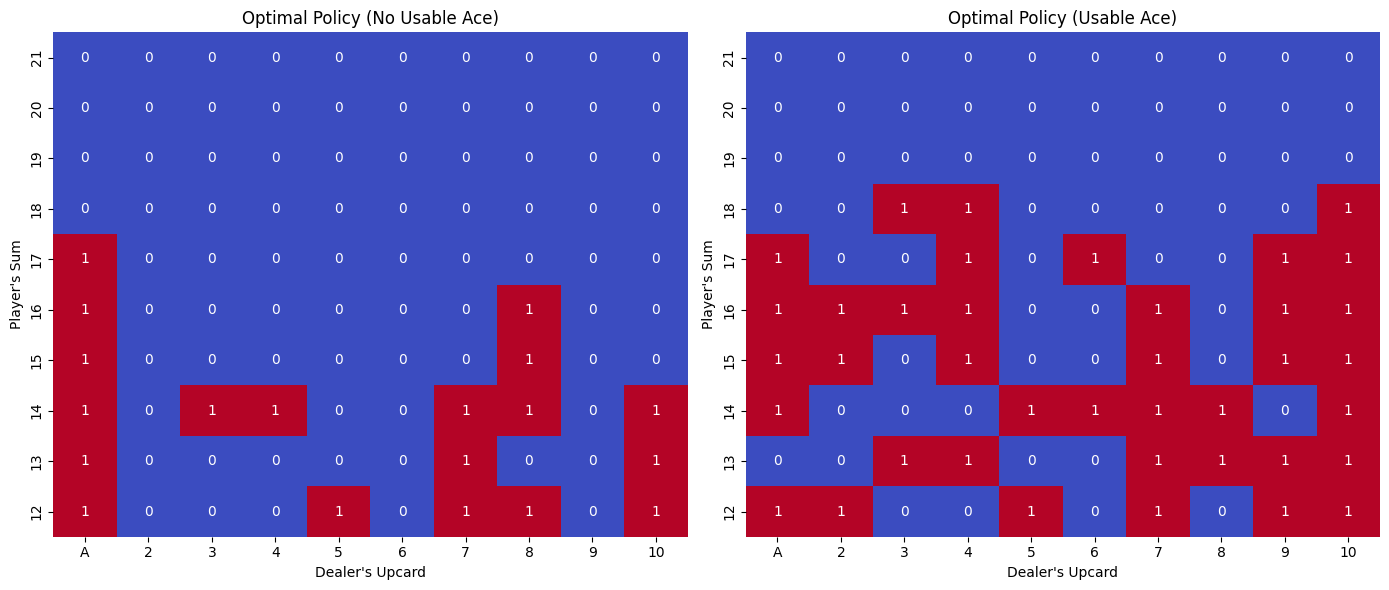


Heatmap Legend: 0 = Stick, 1 = Hit


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

player_sums = range(12, 22)
dealer_cards = range(1, 11)

policy_usable_ace = pd.DataFrame(index=player_sums, columns=dealer_cards, dtype=float)
policy_no_usable_ace = pd.DataFrame(index=player_sums, columns=dealer_cards, dtype=float)

for state, q_values in optimal_Q.items():
    player_sum, dealer_card, usable_ace = state
    if player_sum in player_sums and dealer_card in dealer_cards:
        optimal_action = np.argmax(q_values)
        if usable_ace:
            policy_usable_ace.loc[player_sum, dealer_card] = optimal_action
        else:
            policy_no_usable_ace.loc[player_sum, dealer_card] = optimal_action


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(policy_no_usable_ace.iloc[::-1], annot=True, cmap="coolwarm", fmt=".0f", cbar=False,
            xticklabels=[str(c) if c != 1 else 'A' for c in dealer_cards],
            yticklabels=list(policy_no_usable_ace.index[::-1]))
plt.title("Optimal Policy (No Usable Ace)")
plt.xlabel("Dealer's Upcard")
plt.ylabel("Player's Sum")

plt.subplot(1, 2, 2)
sns.heatmap(policy_usable_ace.iloc[::-1], annot=True, cmap="coolwarm", fmt=".0f", cbar=False,
            xticklabels=[str(c) if c != 1 else 'A' for c in dealer_cards],
            yticklabels=list(policy_usable_ace.index[::-1])) # Reverse y-axis for better readability
plt.title("Optimal Policy (Usable Ace)")
plt.xlabel("Dealer's Upcard")
plt.ylabel("Player's Sum")

plt.tight_layout()
plt.show()

print("\nHeatmap Legend: 0 = Stick, 1 = Hit")